<a href="https://colab.research.google.com/github/FarnazG/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/One_vs_Rest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Modeling:**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import losses

import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# **After 'X' is downloaded:**


In [0]:
# some URL images that were not readable were deleted:
X3 = np.load('/content/drive/My Drive/Capstone Project/X_rgb_df2598.npy') 
X2 = np.load('/content/drive/My Drive/Capstone Project/X_rgb_df2000.npy') 
X1 = np.load('/content/drive/My Drive/Capstone Project/X_rgb_df1000.npy') 
X = np.concatenate((X1, X2, X3))
print(X.shape)


(2598, 360000)


To see how well the image processing works , we will fetch 5 samples from 'X' at random and plot them:

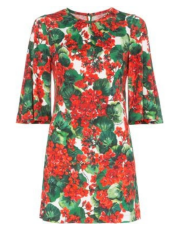

In [0]:
#Select 5 processed images at random from 'X' and plot 
for i in range(0, 1):
  plt.figure()
  plt.imshow(X[i].reshape(400,300,3)), plt.axis('off')

**Splitting the data:**

We need to split the data into training, validation, and test sets.

**Creating the Target Array:**

We already have our 'X'. Now, we need our 'Y'.

We will ceate it from the 'brand.name' column of our dataframe.

this column consists of the categorical labels. then We will map each label with a number using the LabelEncoder.

In [0]:
df= pd.read_csv('/content/drive/My Drive/Capstone Project/df.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,0,41,3440,Dolce & Gabbana,women,True,13951532,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,1124,"$1,124","$1,124",1124,False,Geranium print mini dress,38
1,1,57,25354,Gucci,women,True,13579955,https://cdn-images.farfetch-contents.com/13/57...,https://cdn-images.farfetch-contents.com/13/57...,False,NoTag,9359,SGD,2200,"$2,200","$2,200",2200,False,Stirrups print blouse,13
2,2,122,547344,Saint Laurent,women,True,14031265,https://cdn-images.farfetch-contents.com/14/03...,https://cdn-images.farfetch-contents.com/14/03...,False,NewSeason,9359,SGD,2620,"$2,620","$2,620",2620,False,Zebra print peplum skirt,4
3,3,128,3440,Dolce & Gabbana,women,True,13951202,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,3200,"$3,200","$3,200",3200,False,Lily print flounce dress,18
4,4,96,3440,Dolce & Gabbana,women,True,13922305,https://cdn-images.farfetch-contents.com/13/92...,https://cdn-images.farfetch-contents.com/13/92...,False,NoTag,9541,SGD,4273,"$4,273","$4,273",4273,False,graffiti art print jacket,1


In [0]:
#create dummy variables for 'brand.name' feature:
df_d= pd.get_dummies(df['brand.name'])
df_d

,Chanel Pre-Owned,Dolce & Gabbana,Gucci,Prada,Saint Laurent
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
2593,0,0,0,0,1
2594,0,0,0,0,1
2595,0,1,0,0,0
2596,1,0,0,0,0


In [0]:
# concatenate the dummy variable columns onto the original dataframe
df_f = pd.concat([df,df_d], axis=1)
df_f.head(2)

,Unnamed: 0,Unnamed: 0.1,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal,Chanel Pre-Owned,Dolce & Gabbana,Gucci,Prada,Saint Laurent
0,0,41,3440,Dolce & Gabbana,women,True,13951532,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,1124,"$1,124","$1,124",1124,False,Geranium print mini dress,38,0,1,0,0,0
1,1,57,25354,Gucci,women,True,13579955,https://cdn-images.farfetch-contents.com/13/57...,https://cdn-images.farfetch-contents.com/13/57...,False,NoTag,9359,SGD,2200,"$2,200","$2,200",2200,False,Stirrups print blouse,13,0,0,1,0,0


In [0]:
# we will assign different brands as our target for each neural network:
# first model:

Y= df_f['Chanel Pre-Owned']
Y.shape

(2598,)

**Separation of a validation set, and a test set:**

In [0]:
# we consider 80% of our data as training and 20% as testing:
X_test = X[2000:,]
Y_test = Y[2000:,]

#Seperation of a validation set 15% from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:2000,], Y[:2000,], test_size=0.15, random_state=13, shuffle=True)

**Reshaping the input data**

we already reshaped out images earlier into 360000x1 row arrays, since it was easier to store them that way. But CNN requires input data in form of nice multi-dimensional grids. For our colored image data, the third dimesion will be 3 and for gray-scale is 1.

In [0]:
#Reshape the input matrices such that each sample is three-dimensional
#normalizing images between 0 and 1 while splitting the data: X = X/255

img_rows, img_cols = 400, 300
input_shape = (img_rows, img_cols, 3)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_train = X_train/255
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
X_test = X_test/255
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 3)
X_val = X_val/255

X_val.shape

(300, 400, 300, 3)

# **Convolutional Neural Network**

Compiling the model for binary classification

In [0]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='tanh',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='tanh'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dropout(0.25))

model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

learning_rate = 0.001

model.compile(loss = binary_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 398, 298, 16)      448       
_________________________________________________________________
batch_normalization_8 (Batch (None, 398, 298, 16)      64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 396, 296, 16)      2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 396, 296, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 198, 148, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 198, 148, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 196, 146, 32)     

In [0]:
#Save the model during training 

save_at = "/content/drive/My Drive/Capstone Project/model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

Epoch 1/40
34/34 [==============================] - 337s 10s/step - loss: 1.1203 - accuracy: 0.6406 - val_loss: 1.2245 - val_accuracy: 0.3933
Epoch 2/40
34/34 [==============================] - 390s 11s/step - loss: 0.7080 - accuracy: 0.6806 - val_loss: 0.7910 - val_accuracy: 0.6200
Epoch 3/40
34/34 [==============================] - 329s 10s/step - loss: 0.6867 - accuracy: 0.6759 - val_loss: 1.0278 - val_accuracy: 0.5567
Epoch 4/40
34/34 [==============================] - 496s 15s/step - loss: 0.6779 - accuracy: 0.6894 - val_loss: 0.6117 - val_accuracy: 0.7233
Epoch 5/40
34/34 [==============================] - 340s 10s/step - loss: 0.6786 - accuracy: 0.6659 - val_loss: 0.7381 - val_accuracy: 0.6600
Epoch 6/40
34/34 [==============================] - 322s 9s/step - loss: 0.6543 - accuracy: 0.6812 - val_loss: 0.7065 - val_accuracy: 0.6533
Epoch 7/40
34/34 [==============================] - 492s 14s/step - loss: 0.6510 - accuracy: 0.7082 - val_loss: 0.5995 - val_accuracy: 0.7433
Epoch 8

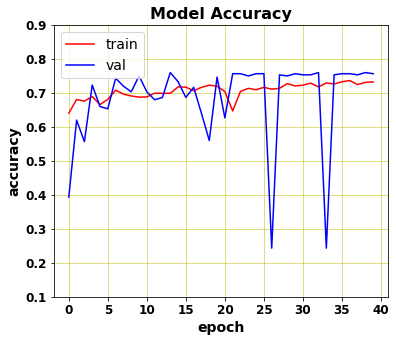

In [0]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 40, batch_size = 50, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

The imbalancement of data for one brand vs rest of them, will cause a false accuracy, cause the model learns that most of the predictions are 0 so it easily predicts 0 for most inputs.
In the next notebook, we are going to balance the data before training and combine the results.

In [0]:
# # Stacking Models

# models = [model1, model2, model3]

# def predict_brand(data):
#   preds = [model.predict_proba(data) for model in models]
#   # model1Pred, model2Pred, model3Pred
#   mean_pred = np.mean(preds)
#   return mean_pred>0.5



# def predict_dg(data):
#   return mean_pred




# def predict_overall(data)
#   pred_gucci = predict_gucci(data)
#   pred_dg = predit_dg(data)
#   predictions = [pred_gucci, pred_dg]
#   return np.argmax(predictions)